## Import and wrangle data into a usable format

Code below to import the dataset and the libraries we need. 

In [64]:
import msoffcrypto
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create an in-memory buffer
temp = io.BytesIO()

# Open the encrypted Excel file
with open('data/NIDC_South East_202324.xlsx', 'rb') as f:
    excel = msoffcrypto.OfficeFile(f)
    excel.load_key(password='Snidc24dow6')
    excel.decrypt(temp)

# Read the decrypted file into a pandas DataFrame
df = pd.read_excel(temp, sheet_name='3. Asset Register')

# Drop columns: '2023/2024 Part 1', 'CollectionName' and 6 other columns
df = df.drop(columns=['2023/2024 Part 1', 
                      'CollectionName', 
                      'RegionCode', 
                      'RegionName', 
                      'ReportingPeriodStart', 
                      'ReportingPeriodEnd', 
                      'SubmittedDatetime', 
                      'SubmissionStatus'])

df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Display the DataFrame
df.head()

,OrganisationCode,OrganisationName,NIDC Asset ID,Local Equipment Identifier,ODS Site Code,Location_Der,Machine_Type_Der,Modality_Der,Equipment Detail Der,Manufacture_Der,...,OOH_Operational_Hours_Mon_Fri,Core_Operational_Hours_Sat,OOH_Operational_Hours_Sat,Core_Operational_Hours_Sun,OOH_Operational_Hours_Sun,Ownership Structure,Ownership_Structure_Der,Capital Purchase Cost,Asset Status,Maintenance Type_Der
0,RDU,Frimley Health NHS Foundation Trust,A160,G3132152,RDU01,Angiography Suite,Image Acquisition,Ultrasound,Ultrasound - General,Hitachi Medical Systems,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty
1,RDU,Frimley Health NHS Foundation Trust,A159,E49106,RDU54,Imaging Department,Image Acquisition,Ultrasound,Ultrasound - General,GE Medical Systems,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty
2,RDU,Frimley Health NHS Foundation Trust,A158,IPX039543,RDU52,Imaging Department,Image Acquisition,Dental,Intraoral,Xograph,...,0.0,12.0,0.0,12.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty
3,RDU,Frimley Health NHS Foundation Trust,A157,TRI2100460,RDU52,Imaging Department,Image Acquisition,X ray Units Mobile,Plain X-Ray-DR Mobile,Hologic,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty
4,RDU,Frimley Health NHS Foundation Trust,A156,3DM160700888,RDU52,Imaging Department,Image Acquisition,Mammography,Symptomatic - Digital Mammography 2D + 3D Tomo...,Hologic,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,403800,In Service,Asset Under Warranty


Count of machine type by asset status

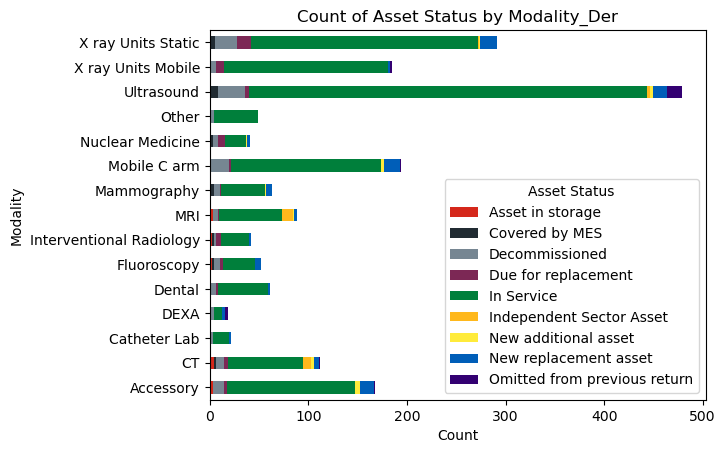

In [29]:
# Count the occurrences
count_data = df.groupby(['Modality_Der', 'Asset Status']).size().unstack().fillna(0)

# NHS colour palette dictionary
nhs_colours = {
    'Asset in storage': '#d5281b', # warm yellow
    'Covered by MES': '#212b32', # black
    'Decommissioned': '#768692', # grey 1
    'Due for replacement': '#7C2855', # red
    'In Service': '#007f3b', # blue
    'Independent Sector Asset': '#ffb81C', # yellow
    'New additional asset': '#ffeb3b', # green
    'New replacement asset': '#005eb8', # yellow
    'Omitted from previous return': '#330072' # purple
}

# Plotting
count_data.plot(kind='barh', stacked=True, color=[nhs_colours[col] for col in count_data.columns])
plt.title('Count of Asset Status by Modality_Der')
plt.xlabel('Count')
plt.ylabel('Modality')
plt.legend(title='Asset Status')
plt.show()

Scatterplot count of modality vs avg age of asset, by provider

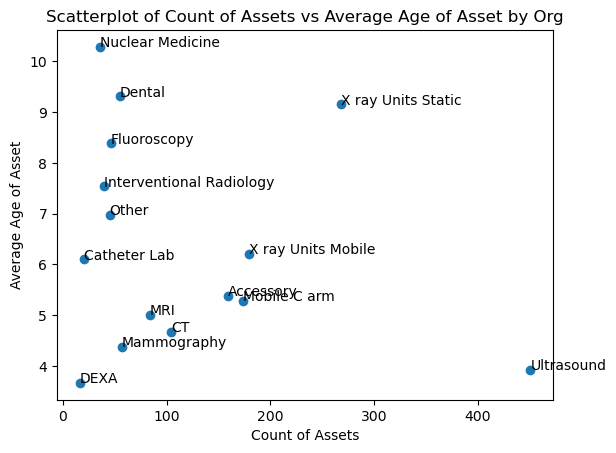

In [45]:
# remove decommissioned assets
df = df[df['Asset Status'] != 'Decommissioned']

# Group by OrganisationName to get the count and average age_of_asset
grouped_df = df.groupby('Modality_Der').agg(
    count_modality=('Modality_Der', 'count'),
    avg_age_of_asset=('Age', 'mean')
).reset_index()


# Create a scatter plot
plt.scatter(grouped_df['count_modality'], grouped_df['avg_age_of_asset'])

# Add labels and title
plt.xlabel('Count of Assets')
plt.ylabel('Average Age of Asset')
plt.title('Scatterplot of Count of Assets vs Average Age of Asset by Org')

# Label dots with OrganisationName
for i, row in grouped_df.iterrows():
    plt.text(row['count_modality'], row['avg_age_of_asset'], row['Modality_Der'])

# Show the plot
plt.show()

Asset type by age

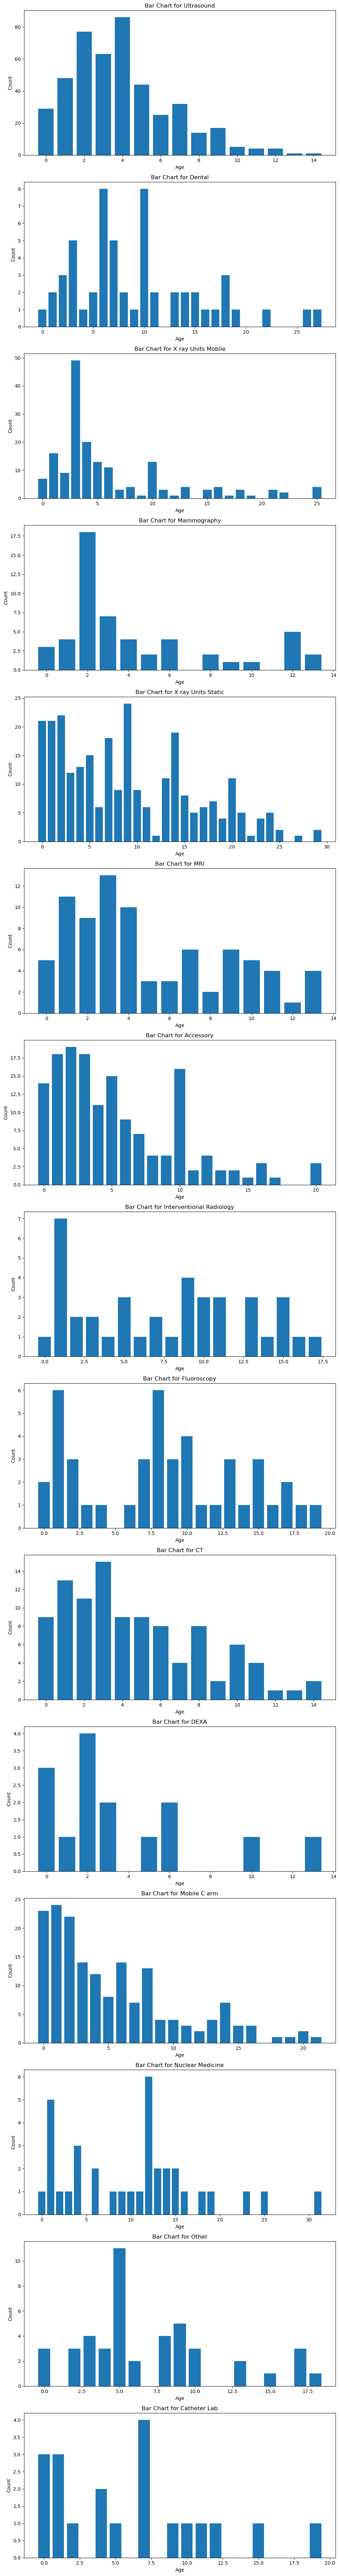

In [66]:
# remove decommissioned assets
df = df[df['Asset Status'] != 'Decommissioned']

# Get unique Modality_Der values
modalities = df['Modality_Der'].unique()

# Create subplots for each Modality_Der
fig, axes = plt.subplots(nrows=len(modalities), ncols=1, figsize=(10, 5 * len(modalities)))

# If there's only one subplot, convert axes to a list
if len(modalities) == 1:
    axes = [axes]

# Group by OrganisationName to get the count and average age_of_asset
for i, modality in enumerate(modalities):
    modality_df = df[df['Modality_Der'] == modality]
    grouped_df = modality_df.groupby('Age').agg(
        count_modality=('Modality_Der', 'count')
    ).reset_index()

    # Creating the bar plot
    axes[i].bar(grouped_df['Age'], grouped_df['count_modality'])
    axes[i].set_title(f'Bar Chart for {modality}')
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Count')

    # # Label bars with age
    # for j, row in grouped_df.iterrows():
    #     axes[i].text(j, row['count_modality'], row['Age'], ha='center')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Replacement schedule and cost dictionaries

In [76]:
replacement_schedule = {
'Accessory': 5,
'CT': 8,
'Catheter Lab': 8,
'DEXA': 10,
'Dental': 10,
'Fluoroscopy': 8,
'Interventional Radiology': 8,
'MRI': 8,
'Mammography': 5,
'Mobile C arm': 8,
'Nuclear Medicine': 8,
'Other': 0,
'Ultrasound': 5,
'X ray Units Mobile': 8,
'X ray Units Static': 8,
}

replacement_cost = {
'Accessory': 22500,
'CT': 935000,
'Catheter Lab': 900000,
'DEXA': 88000,
'Dental': 33000,
'Fluoroscopy': 660000,
'Interventional Radiology': 935000,
'MRI': 1210000,
'Mammography': 330000,
'Mobile C arm': 90000,
'Nuclear Medicine': 880000,
'Other': 0,
'Ultrasound': 90000,
'X ray Units Mobile': 85000,
'X ray Units Static': 120000,
}

Stacked bar chart by provider

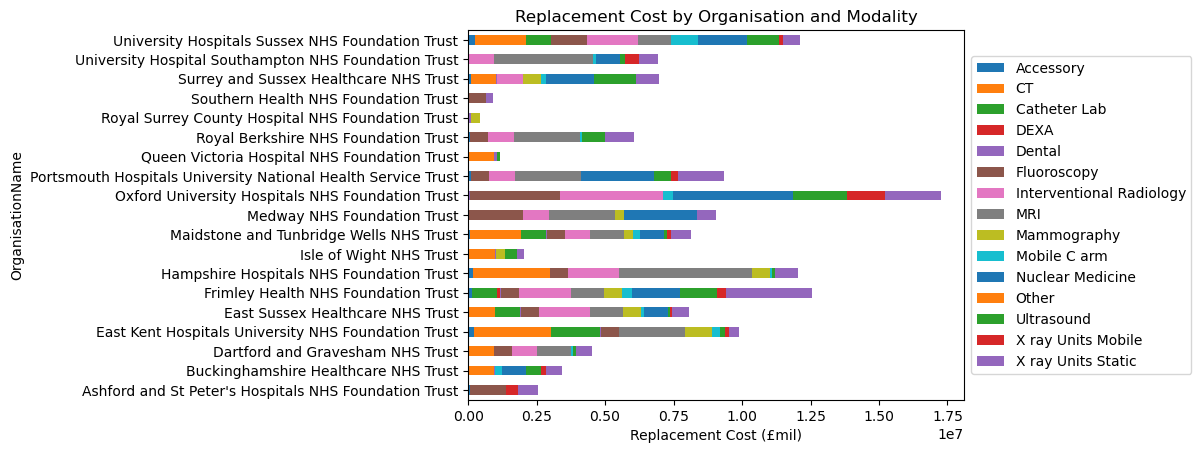

,OrganisationCode,OrganisationName,NIDC Asset ID,Local Equipment Identifier,ODS Site Code,Location_Der,Machine_Type_Der,Modality_Der,Equipment Detail Der,Manufacture_Der,...,OOH_Operational_Hours_Sat,Core_Operational_Hours_Sun,OOH_Operational_Hours_Sun,Ownership Structure,Ownership_Structure_Der,Capital Purchase Cost,Asset Status,Maintenance Type_Der,replacement_cost,replacement_schedule
18,RN7,Dartford and Gravesham NHS Trust,A028,120450,RN707,Imaging Department,Image Acquisition,Interventional Radiology,Single Plane,Philips Healthcare,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,450000,In Service,Manufacturer provides maintenance,935000,8
33,RHW,Royal Berkshire NHS Foundation Trust,A060,Aplioi 700 WBCH Rm 2,O412S,Community Diagnostic Centre NHS Asset,Image Acquisition,Ultrasound,Ultrasound - General,Canon,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56400,In Service,Manufacturer provides maintenance,90000,5
36,RHW,Royal Berkshire NHS Foundation Trust,A079,Philips cx50 IR uss,RHW01,Angiography Suite,Image Acquisition,Ultrasound,2D with CEUS / Elastography / Fusion Capabilit...,Philips Healthcare,...,0.0,24.0,0.0,Capital purchase - new,Capital purchase - new,51734,New replacement asset,No Maintenance in Place,90000,5
37,RTP,Surrey and Sussex Healthcare NHS Trust,A014,ES-EPU US,RTP04,Maternity Department,Image Acquisition,Ultrasound,2D – Obstetric,GE Medical Systems,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,50000,In Service,Manufacturer provides maintenance,90000,5
40,RYR,University Hospitals Sussex NHS Foundation Trust,A006,RAD0019,RXH09,Imaging Department,Image Acquisition,X ray Units Static,Plain X-Ray-DR Static,Siemens Healthcare,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,180000,In Service,Third Party Supplier provides maintenance,120000,8


In [84]:
# remove decommissioned assets
df = df[df['Asset Status'] != 'Decommissioned']

# Add replacement_cost to the DataFrame
df['replacement_cost'] = df.apply(lambda row: replacement_cost[(row['Modality_Der'])], axis=1)
df['replacement_schedule'] = df.apply(lambda row: replacement_schedule[(row['Modality_Der'])], axis=1)

# Only where Age > replacement_schedule
df = df[df['Age'] > df['replacement_schedule']]

# Pivot the DataFrame to get the data in the format required for a stacked bar chart
pivot_df = df.pivot_table(index='OrganisationName', columns='Modality_Der', values='replacement_cost', aggfunc='sum').fillna(0)

# Create a stacked bar chart
pivot_df.plot(kind='barh', stacked=True)

# Add labels and title
plt.xlabel('Replacement Cost (£mil)')
plt.ylabel('OrganisationName')
plt.title('Replacement Cost by Organisation and Modality')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

Fit a Decision Tree model.

In [12]:
model = DecisionTreeClassifier()
model = model.fit(X_train,y_train)

Use the trained model to predict labels in both training and test sets, and calculate and compare accuracy.

In [13]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print(f"Accuracy of predicting training data = {accuracy_train:.3%}")
print(f"Accuracy of predicting testing data = {accuracy_test:.3%}")

Accuracy of predicting training data = 100.000%
Accuracy of predicting testing data = 70.777%


Calculate the additional model metrics for the test data only.

- precision
- specificity
- recall (sensitivity)

Return the 'micro' average in each case.

In [14]:
precision_score_test = precision_score(y_test, y_pred_test, average='micro')
recall_sensitivity_score_test = recall_score(y_test, y_pred_test, 
                                             average='micro')
specificity_score_test = precision_score(y_test, y_pred_test, pos_label=0)

print(f"Precision score for testing data = {precision_score_test:.3%}")
print(f"Recall (sensitivity) score for testing data = {recall_sensitivity_score_test:.3%}")
print(f"Specificity score for testing data = {specificity_score_test:.3%}")

Precision score for testing data = 70.777%
Recall (sensitivity) score for testing data = 70.777%
Specificity score for testing data = 74.654%


Plot the decision tree.

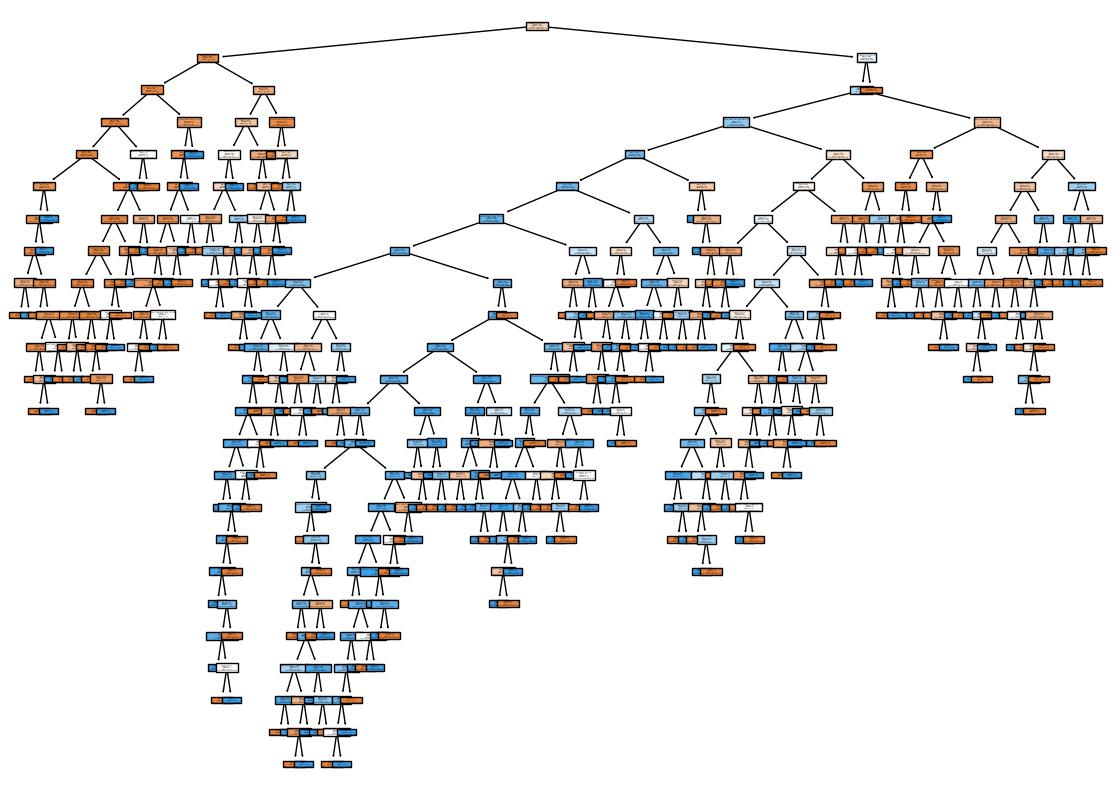

In [16]:
fig, ax = plt.subplots(figsize=(14,10))

fig = plot_tree(
    model,
    feature_names = X.columns.tolist(),
    class_names=["Not Given Clotbuster", "Given Clotbuster"],
    filled = True,
    ax=ax
)

plt.show()


## Extension - Refining Your Decision Tree

Let's experiment by changing a few parameters.

### Maximum Depth

Try changing the value of the 'max_depth' parameter when setting up your DecisionTreeClassifier.

### Minimum Samples

Try changing the values of 'min_samples_split' (the default value is 2).

Now try adjusting 'min_samples_leaf' (the default is 1).

### Split Criterion

Compare the performance when using 

- Gini Impurity
- Entropy
- Log Loss

## Comparing Performance with a Logistic Regression Model

Copy your code in from last week's logistic regression exercise (or write this in from scratch - there isn't much that is different to the decision tree model!). 

**Remember - you will need to standardise the data for the logistic regression model!**

Look at these additional metrics as well:

- precision
- specificity
- recall (sensitivity)

Use the cell below to write out an interpretation of the performance of the logistic regression model and the decision tree. 

Think about the presence of **false positives** and **false negatives**. 

Which might you be more interested in minimizing in this model? 

Hint - giving thrombolysis to good candidates for it can lead to less disability after stroke and improved outcomes. However, there is a risk that giving thrombolysis to the wrong person could lead to additional bleeding on the brain and worse outcomes. What might you want to balance?

## Challenge Exercises

### Bonus Exercise 1

Have a read of this article on feature importance in decision trees: [Article Link](https://www.codecademy.com/article/fe-feature-importance-final)

In particular, make sure you read the section "Pros and cons of using Gini importance" so you can understand some of the things you need to keep in mind when looking at feature importance in trees.

We can access the feature importance by running the following code:

In [ ]:
# modify this code to point towards your decision tree model object (make sure that object
# was using the gini index as the criteria)
feature_importances = _______.feature_importances_

How does this compare to the feature importance for your logistic regression?

In [ ]:
# modify this code to point towards your logistic regression model object
feature_importances = _______.feature_importances_

Can you create two graphs showing feature importance for the two models?

Instead of using the plot code used in the linked article, try looking up the 
`barh` function from matplotlib. 

Try ordering your plot so that the features with the most importance are at the top.

### Bonus Exercise 2
Can you improve accuracy of your decision tree model by changing the size of your train / test split?  



### Bonus Exercise 3

Try dropping some features from your data.  

Can you improve the performance of your model this way?